# Homework: Implement a Mixture of Experts Model

## Overview

In this homework, you'll implement a Mixture of Experts (MoE) model for classifying points generated from two Gaussian distributions.

Please submit your Jupyter Notebook with all the completed tasks and questions answered.

In [ ]:
# Import Libraries

import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

import numpy as np
import matplotlib.pyplot as plt

from IPython import display

In [ ]:
# Generate the Dataset
def generate_data(n_samples=2000):
  X = torch.zeros(n_samples, 2)
  y = torch.zeros(n_samples, dtype=torch.long)

  # Generate samples from two Gaussian distributions
  X[:n_samples//2] = torch.randn(n_samples//2, 2) + torch.Tensor([3,2])
  X[n_samples//2:] = torch.randn(n_samples//2, 2) + torch.Tensor([-3,2])

  # Labels
  for i in range(X.shape[0]):
    if X[i].norm() > math.sqrt(13):
      y[i] = 1

  X[:, 1] = X[:, 1] - 2

  return X, y

data, labels = generate_data()

Question: Plot the generated dataset. Do you think a linear model would be able to separate the classes well?

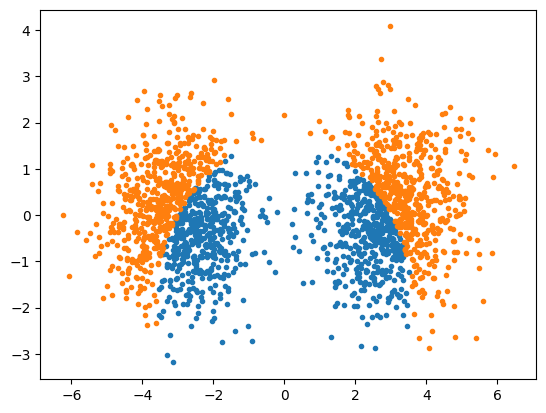

In [ ]:
# Visualize the data
# TODO
plt.scatter(data[labels == 0][:,0],data[labels == 0][:,1],marker=".")
plt.scatter(data[labels == 1][:,0],data[labels == 1][:,1],marker=".");

Clearly, a single linear model isn't enough to separate the data

## Expert Model

Task: Implement the Expert model. It should be a simple neural network with one linear layer.



In [ ]:
class Expert(nn.Module):
  def __init__(self, input_size, hidden_size):
    super().__init__()
    self.linear = nn.Linear(input_size,hidden_size)

  def forward(self, x):
    return self.linear(x)

## Gating Network

Task: Implement the Gating Network. It should output the probabilities for choosing each expert.

In [ ]:
class GatingNetwork(nn.Module):
  # TODO
  def __init__(self, input_size, hidden_size, num_experts):
    super().__init__()
    self.linear1 = nn.Linear(input_size, hidden_size)
    self.linear2 = nn.Linear(hidden_size, num_experts)
    self.softmax = nn.Softmax(dim=1)

  def forward(self,x):
    x = self.linear1(x)
    x = self.linear2(x)
    x = self.softmax(x)
    return x

## Mixture of Experts

Task: Implement the Mixture of Experts model. This model should utilize the Expert and Gating Network models to make a final prediction.

In [ ]:
class MixtureOfExperts(nn.Module):
  def __init__(self, num_experts=2):
    super().__init__()
    self.num_experts = num_experts
    self.experts = [Expert(2, 100) for _ in range(self.num_experts)]
    self.gating = GatingNetwork(2, 100, self.num_experts)
    self.linear = nn.Linear(100, 2)

  def forward(self, x):
    z = self.gating.forward(x)
    h = torch.stack([self.experts[i].forward(x) for i in range(self.num_experts)])
    s = torch.mul(h,z.T[:,:,None]).sum(dim=0)
    out = self.linear(s)
    return out  ## Returning

## Training Loop

Task: Write a training loop to train the Mixture of Experts model. Use binary cross-entropy loss and an Adam optimizer. Also, implement a learning rate scheduler that decays the learning rate.

In [ ]:
# Define the model, loss, and optimizer
model = MixtureOfExperts() # TODO
criterion = nn.CrossEntropyLoss() # TODO
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3) # TODO

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=30) # TODO

# Convert data and labels to float tensors
data_tensor = data.float()
labels_tensor = labels.float()

# Training loop
num_epochs = 2000 # 2000 #
for epoch in range(num_epochs):
    # Forward pass
    # TODO
    labels_pred = model.forward(data_tensor)

    # Backward pass and optimization
    # TODO
    loss = criterion(labels_pred, labels)

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

    # Decay the learning rate
    # TODO
    before_lr = optimizer.param_groups[0]["lr"]
    scheduler.step()
    after_lr = optimizer.param_groups[0]["lr"]

    # Print out the loss and accuracy
    score, predicted = torch.max(labels_pred, 1)
    acc = (predicted == labels).sum().float() / len(labels)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (epoch, loss.item(), acc))
    display.clear_output(wait=True)


[EPOCH]: 1999, [LOSS]: 0.088625, [ACCURACY]: 0.970


## Decision Boundaries
Task: Plot the decision boundaries of the two experts, the gating network and the final model

In [ ]:
X = data
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

The Gating Netwrok Decision Boundary

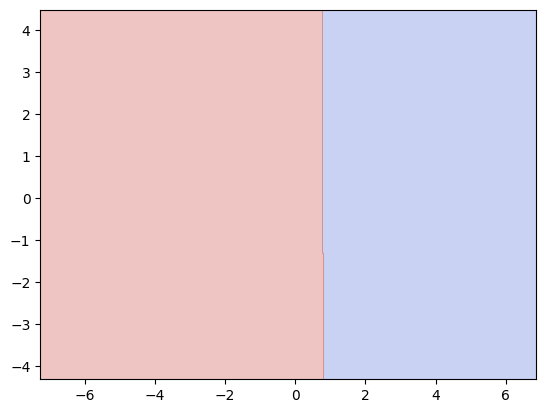

In [ ]:
with torch.no_grad():
    mesh_data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
    Z = model.gating(mesh_data).detach()
Z = np.argmax(Z, axis=1).reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.3);

The Two Experts

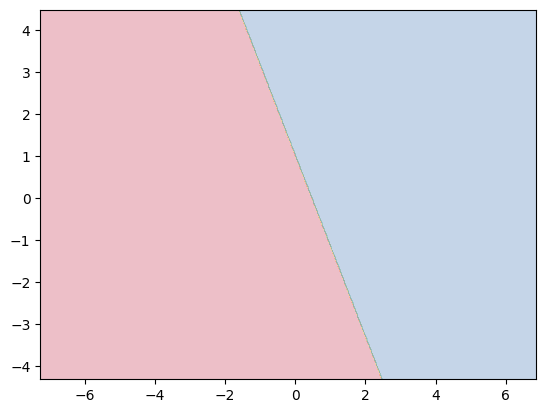

In [ ]:
with torch.no_grad():
    mesh_data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
    Z = model.experts[0](mesh_data).detach()
    Z = model.linear(Z)
Z = np.argmax(Z, axis=1).reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3);

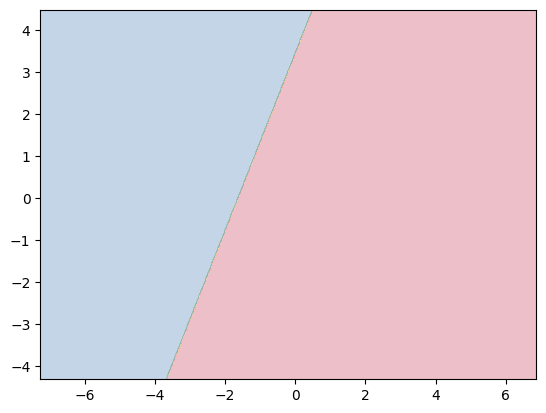

In [ ]:
with torch.no_grad():
    mesh_data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
    Z = model.experts[1](mesh_data).detach()
    Z = model.linear(Z)
Z = np.argmax(Z, axis=1).reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3);

And, the final model

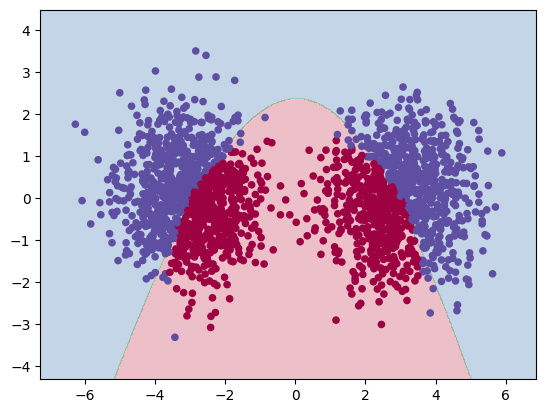

In [ ]:
with torch.no_grad():
    mesh_data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
    Z = model(mesh_data).detach()
Z = np.argmax(Z, axis=1).reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral,alpha=0.3)

plt.scatter(data[:,0],data[:,1],s=20,c=labels,cmap=plt.cm.Spectral);

Question: Analyze the decision boundaries. What differences do you observe between the experts? How does the gating network decide between the two?

The two decision boundaries classify the points according to the labels (pink vs blue in the respective regions), neither one can completely classify the given data.
The gating network divides the region, not according to the class labels, but according to the weights it learn for the experts. The final prediction is the weighted sum of the prediction by the experts, with the gate effectively switching over from one to the other. This would be our the final decision boundary

## Bonus Task (2 points)
Try increasing the number of experts. How does the model complexity and decision boundary change? (You don't need to show your code for the new models, just plot the new decision boundaries and explain what did you find from the plots)



In [ ]:
# Define the model, loss, and optimizer
model = MixtureOfExperts(num_experts=5) # TODO
criterion = nn.CrossEntropyLoss() # TODO
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3) # TODO

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=30) # TODO

# Convert data and labels to float tensors
data_tensor = data.float()
labels_tensor = labels.float()

# Training loop
num_epochs = 2000 # 2000 #
for epoch in range(num_epochs):
    # Forward pass
    # TODO
    labels_pred = model.forward(data_tensor)

    # Backward pass and optimization
    # TODO
    loss = criterion(labels_pred, labels)

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

    # Decay the learning rate
    # TODO
    before_lr = optimizer.param_groups[0]["lr"]
    scheduler.step()
    after_lr = optimizer.param_groups[0]["lr"]

    # Print out the loss and accuracy
    score, predicted = torch.max(labels_pred, 1)
    acc = (predicted == labels).sum().float() / len(labels)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (epoch, loss.item(), acc))
    display.clear_output(wait=True)


[EPOCH]: 1999, [LOSS]: 0.017413, [ACCURACY]: 0.996


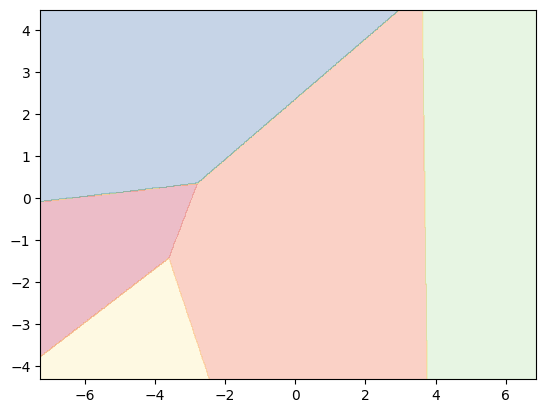

In [ ]:
with torch.no_grad():
    mesh_data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
    Z = model.gating(mesh_data).detach()
Z = np.argmax(Z, axis=1).reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3);

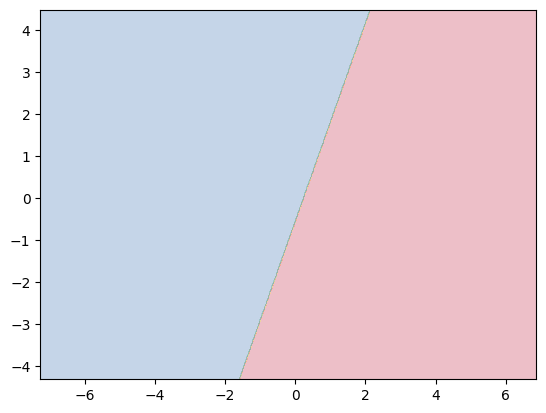

In [ ]:
with torch.no_grad():
    mesh_data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
    Z = model.experts[0](mesh_data).detach()
    Z = model.linear(Z)
Z = np.argmax(Z, axis=1).reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3);

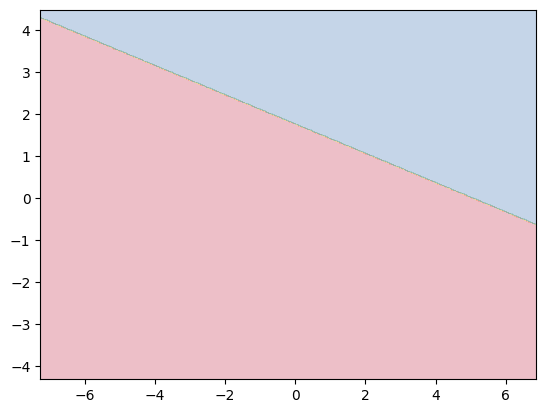

In [ ]:
with torch.no_grad():
    mesh_data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
    Z = model.experts[1](mesh_data).detach()
    Z = model.linear(Z)
Z = np.argmax(Z, axis=1).reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3);

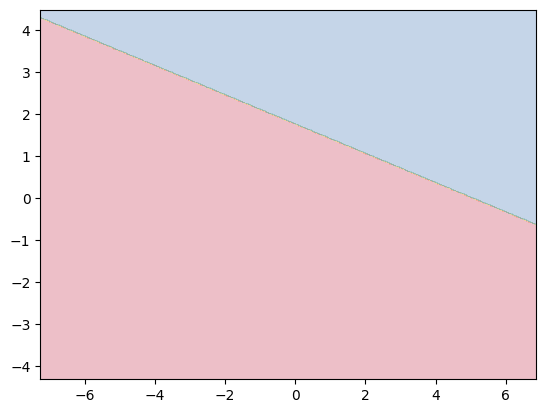

In [ ]:
with torch.no_grad():
    mesh_data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
    Z = model.experts[2](mesh_data).detach()
    Z = model.linear(Z)
Z = np.argmax(Z, axis=1).reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3);

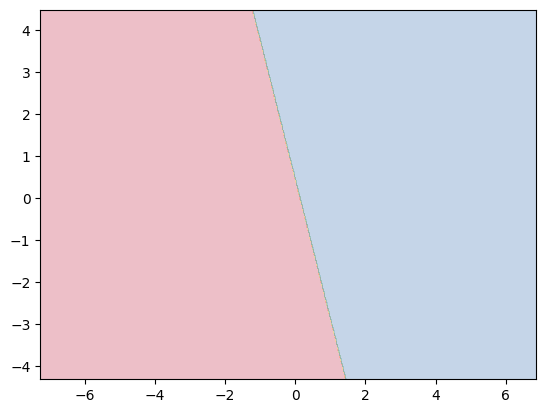

In [ ]:
with torch.no_grad():
    mesh_data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
    Z = model.experts[3](mesh_data).detach()
    Z = model.linear(Z)
Z = np.argmax(Z, axis=1).reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3);

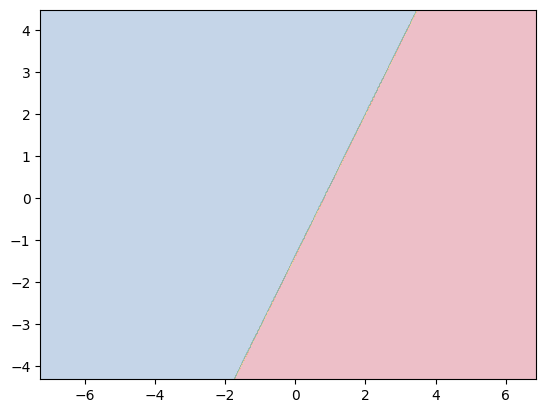

In [ ]:
with torch.no_grad():
    mesh_data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
    Z = model.experts[4](mesh_data).detach()
    Z = model.linear(Z)
Z = np.argmax(Z, axis=1).reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3);

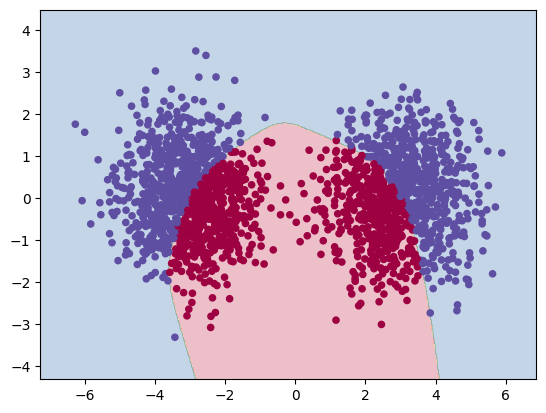

In [ ]:
with torch.no_grad():
    mesh_data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
    Z = model(mesh_data).detach()
Z = np.argmax(Z, axis=1).reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral,alpha=0.3)

plt.scatter(data[:,0],data[:,1],s=20,c=labels,cmap=plt.cm.Spectral);

The expert decision boundaries are still linear (as would be expected) but now as the gating network is switching over more 5 experts and so the model complexity has increased; in fact, now, the model seems to be overfitting the data.